<font color="green">**Generate a single sequence to sequence model for the entire predictions. The model predicts the first 15 days of the test data. Then using the actual 15 day prices, predicts the next 15 days. This process continues till all the test values are predicted.**</font>

In [ ]:
import numpy as np
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
import pandas_datareader as web
import keras
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

**Get stock data**

In [ ]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2015-01-01', end='2020-09-02') 
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.696352
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.000614
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.002876
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.339447
2015-01-08,28.037500,27.174999,27.307501,27.972500,237458000.0,25.274624


**Train test data split and generate batches of 15 day prices. This is because a sequence to sequence model uses 15 day window to predict next 15 day prices.**

In [ ]:
train_data_df, test_data_df = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
train_data = train_data_df['Close'].values
test_data = test_data_df['Close'].values

In [ ]:
trainlist = train_data.tolist()
decoder_input = []
x_train = []
y_train = []
for i in range(15,len(trainlist)-15):
  decoder_input.append(15*[0])
  x_train.append(trainlist[i-15:i])
  y_train.append(trainlist[i:i+15])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
decoder_input = np.array(decoder_input)

In [ ]:
testlist = test_data.tolist()
decoder_input_test = []
x_test = [trainlist[-15:]]
y_test = [testlist[:15]]
decoder_input_test.append(15*[0])
for i in range(15,len(testlist)-15,15):
  decoder_input_test.append(15*[0])
  x_test.append(testlist[i-15:i])
  y_test.append(testlist[i:i+15])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)
decoder_input_test = np.array(decoder_input_test)

In [ ]:
print(x_train.shape)

(1112, 15)


**Initialize hyperparameters**

In [ ]:
keras.backend.clear_session()

layers = [35, 35] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 15
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

num_signals = 2 # The number of random sine waves the compose the signal. The more sine waves, the harder the problem.

**Model Encoder neural network using GRU**

In [ ]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    """encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))"""
print(encoder_cells[0])
encoder = keras.layers.RNN(encoder_cells, return_state=True)
#encoder = keras.layers.LSTM(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

**Model Decoder neural network using GRU**

In [ ]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    """decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))"""

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)
#decoder = keras.layers.LSTM(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

**Generate Model**

In [1]:

# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

NameError: name 'keras' is not defined

**Train Model**

In [ ]:
model.fit([x_train,decoder_input],y_train, steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/15
200/200 [==============================] - 4s 20ms/step - loss: 238.1152
Epoch 2/15
200/200 [==============================] - 4s 20ms/step - loss: 83.3544
Epoch 3/15
200/200 [==============================] - 4s 20ms/step - loss: 82.0955
Epoch 4/15
200/200 [==============================] - 4s 21ms/step - loss: 79.0706
Epoch 5/15
200/200 [==============================] - 4s 20ms/step - loss: 82.2290
Epoch 6/15
200/200 [==============================] - 4s 20ms/step - loss: 84.8802
Epoch 7/15
200/200 [==============================] - 4s 20ms/step - loss: 81.5131
Epoch 8/15
200/200 [==============================] - 4s 20ms/step - loss: 79.7015
Epoch 9/15
200/200 [==============================] - 4s 20ms/step - loss: 80.8411
Epoch 10/15
200/200 [==============================] - 4s 22ms/step - loss: 84.3440
Epoch 11/15
200/200 [==============================] - 4s 22ms/step - loss: 80.0157
Epoch 12/15
200/200 [==============================] - 4s 20ms/step - loss: 83.1249


**Generate first 15 day predictions and visualize them**

In [ ]:
new_x_test = np.array([y_train[-1]])
new_decoded = np.array([15*[0]])
y_test_predicted = model.predict([new_x_test,new_decoded])

In [ ]:
print(new_x_test.shape,new_decoded.shape)

(1, 15) (1, 15)


In [ ]:
print(y_test_predicted[0])

[[36.894775]
 [36.89675 ]
 [36.89677 ]
 [36.89678 ]
 [36.896782]
 [36.89678 ]
 [36.89678 ]
 [36.89678 ]
 [36.89677 ]
 [36.896767]
 [36.896763]
 [36.896763]
 [36.896755]
 [36.896748]
 [36.896748]]


In [ ]:
print(x_test[0])

[49.95000076 49.93500137 49.47999954 50.38750076 50.68249893 51.10250092
 51.05749893 50.00500107 50.31000137 50.80749893 50.4375     50.82500076
 51.30250168 51.125      50.83750153]


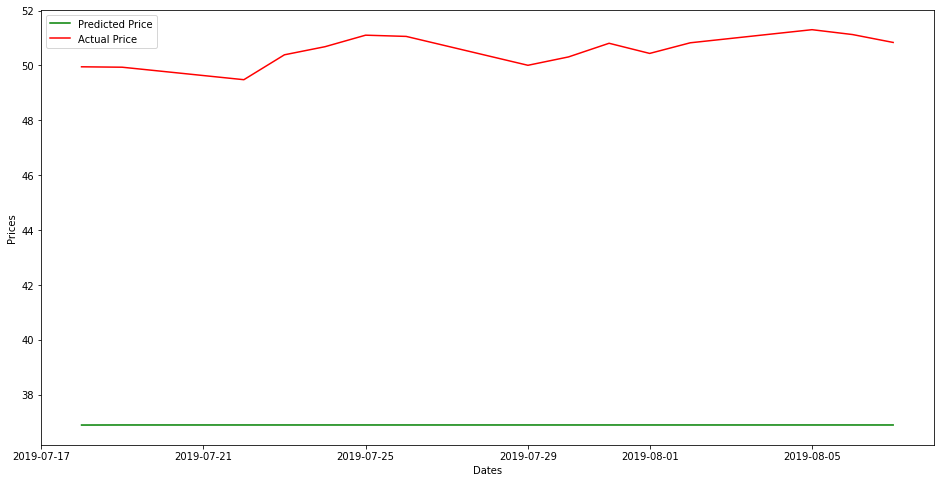

In [ ]:
plt.figure(figsize=(16,8))
#plt.plot(train_data['Close'], label='Training Data')
#plt.plot(df['Close'], label='Training Data')
#print(test_data.index)
plt.plot(test_data_df.index[:15], y_test_predicted[0], color='green', label='Predicted Price')
plt.plot(test_data_df.index[:15], x_test[0], color='red', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

**Calculate Error**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
error = mean_absolute_percentage_error(x_test[0], y_test_predicted[0])
print(error)

27.001534930384047


In [ ]:
error = mean_squared_error(x_test[0], y_test_predicted[0])
#error = mean_absolute_error(x_test[0], y_test_predicted[0])
print(error)

186.67040854848844


In [ ]:
new_test = []
i = 15
sp = 100
while i:
  new_test.append(sp)
  sp+=1
  i-=1
print(new_test)
new_x_test = np.array([new_test])
new_decoded = np.array([15*[0]])
new_pred = model.predict([new_x_test,new_decoded])
print(new_pred)

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
[[[50.441784]
  [53.15031 ]
  [53.802143]
  [53.900696]
  [53.914658]
  [53.9166  ]
  [53.916805]
  [53.91671 ]
  [53.916557]
  [53.916393]
  [53.916233]
  [53.91609 ]
  [53.915947]
  [53.915825]
  [53.915718]]]


**Generate predictions for the complete test data**

In [ ]:
y_test_predicted = []
for window in x_test:
  new_x_test = np.array([window])
  cur_predicted = model.predict([new_x_test,new_decoded])
  cur_predicted = cur_predicted.tolist()
  #print(cur_predicted)
  for stock in cur_predicted[0]:
    y_test_predicted.append(stock[0])
print(y_test_predicted)

[50.087894439697266, 52.07019805908203, 52.48065948486328, 52.02863311767578, 51.492252349853516, 51.30906677246094, 51.31247329711914, 51.343055725097656, 51.379638671875, 51.416446685791016, 51.45417785644531, 51.492698669433594, 51.53190994262695, 51.57167053222656, 51.61191940307617, 50.099056243896484, 52.110198974609375, 52.54246520996094, 52.1154899597168, 51.570369720458984, 51.376644134521484, 51.376976013183594, 51.40803146362305, 51.445438385009766, 51.483036041259766, 51.521514892578125, 51.560791015625, 51.60076141357422, 51.64128875732422, 51.68229675292969, 50.15067672729492, 52.290767669677734, 52.8189811706543, 52.522911071777344, 51.96826934814453, 51.723812103271484, 51.702857971191406, 51.734256744384766, 51.775150299072266, 51.81624984741211, 51.857933044433594, 51.900367736816406, 51.94349670410156, 51.987144470214844, 52.031185150146484, 50.26200485229492, 52.64691925048828, 53.315956115722656, 53.279781341552734, 52.952083587646484, 52.673255920410156, 52.577518

In [ ]:
final_predictions = []
for window in y_test_predicted:
  window = window.tolist()
  w = []
  #print(window)
  for price in window:
    w.append(price[0])
  final_predictions.extend(w)

i = 15
while i:
  final_predictions.pop()
  i-=1
print(len(final_predictions))

270


In [ ]:
len(test_data)

286

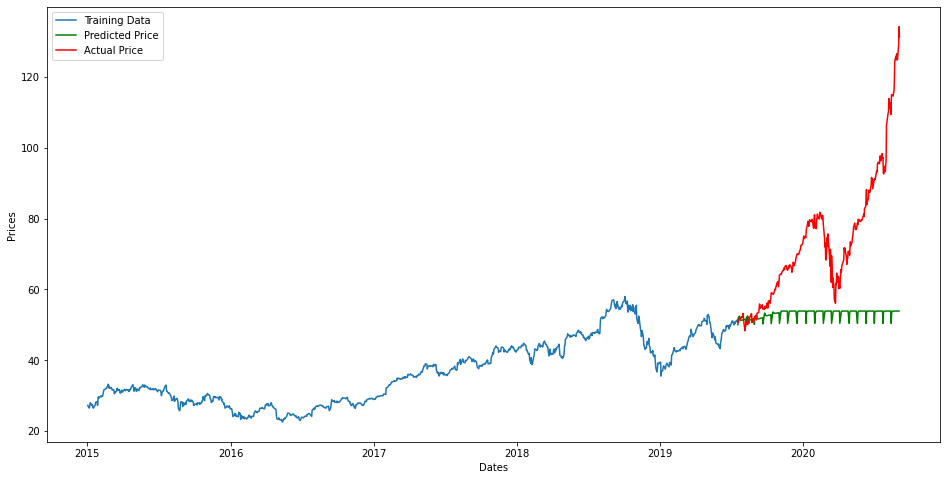

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_data_df.index,train_data, label='Training Data')
#plt.plot(df['Close'], label='Training Data')
#print(test_data.index)
plt.plot(test_data_df.index[:-1], y_test_predicted, color='green', label='Predicted Price')
plt.plot(test_data_df.index, test_data, color='red', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()